In [1]:
import jax
import jax.numpy as jnp
from jax import grad, random
from jax import lax
import unittest
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
#!pip install optax
import optax

In [3]:
# Random key
key = jax.random.PRNGKey(42)

# Sampling from Binomial
def binomial_f(key, n, p, num_samples):
    return jax.random.binomial(key, n=n, p=p, shape=(num_samples,)).astype(int)

# Log-probability of Binomial sample
def log_binomial(x, n, p):
    return x * jnp.log(p) + (n - x) * jnp.log(1 - p)

# Gradient of log P(x | p) w.r.t. p
def grad_log_binomial(x, n, p):
    return jax.grad(lambda p_: log_binomial(x, n, p_))(p)

# REINFORCE-style estimator
def reinforce(key, n, p, num_samples, sample_fn, grad_log_prob_fn, reward_fn=lambda x: x):
    # Sample from the distribution
    key, subkey = jax.random.split(key)
    samples = sample_fn(subkey, n, p, num_samples)
    
    # Apply reward function (can be identity or custom)
    rewards = reward_fn(samples)

    # Vectorize gradient function
    grad_fn = jax.vmap(lambda x: grad_log_prob_fn(x, n, p))
    grads = grad_fn(samples)

    # Estimate expected gradient using REINFORCE
    return jnp.mean(rewards * grads), samples, grads


# Parameters
n = 6
p = 0.3
num_samples = 1000000
sample_fn = binomial_f
grad_log_prob_fn = grad_log_binomial

# Run REINFORCE
grad_estimate, samples, grads = reinforce(key, n, p, num_samples, sample_fn, grad_log_prob_fn)

print("Estimated REINFORCE gradient for Binomial Distribution:", grad_estimate)

Estimated REINFORCE gradient for Binomial Distribution: 5.9976153


In [5]:
#random walk
def s_to_random_walk(s, n):
    return 2 * s - n

def random_walk_to_s(w, n):
    return (w + n) // 2 

def random_walk_f(key, n, p, num_samples):
    return s_to_random_walk(binomial_f(key, n, p, num_samples), n)

def grad_log_random_walk(w, n, p):
    s = random_walk_to_s(w, n)
    return grad_log_binomial(s, n, p)

#parameters
key = jax.random.PRNGKey(42)
n = 10
p = 0.3
num_samples = 100000
#convert binomial to random walk sample
sample_fn=random_walk_f
grad_log_prob_fn=grad_log_random_walk

#run
grad_estimate, samples_w, grads = reinforce(key, n, p, num_samples, sample_fn, grad_log_prob_fn)

print("Estimated REINFORCE gradient for Random Walk:", grad_estimate)


Estimated REINFORCE gradient for Random Walk: 20.125715


In [7]:
def findNextGen(mat):
    m, n = mat.shape

    directions = [(0, 1), (1, 0), (0, -1), (-1, 0),
                  (1, 1), (-1, -1), (1, -1), (-1, 1)]

    for i in range(m):
        for j in range(n):
            live = 0

            for dx, dy in directions:
                x, y = i + dx, j + dy
                if 0 <= x < m and 0 <= y < n and (mat[x, y] == 1 or mat[x, y] == 3):
                    live += 1

            if mat[i, j] == 1 and (live < 2 or live > 3):
                mat = mat.at[i, j].set(3)
            elif mat[i, j] == 0 and live == 3:
                mat = mat.at[i, j].set(2)

    # Finalize state transitions
    
    for i in range(m):
        for j in range(n):
            if mat[i, j] == 2:
                mat = mat.at[i, j].set(1)
            elif mat[i, j] == 3:
                mat = mat.at[i, j].set(0)
            print(mat[i, j], end=" ")
        print()

    #return mat



In [9]:
p = 0.5
N = 10
key = jax.random.PRNGKey(42)   # master key
key, subkey = jax.random.split(key)  # use subkey for sampling
grid = jax.random.bernoulli(subkey, p=p, shape=(N, N)).astype(jnp.int32)
print(grid)
findNextGen(grid)

[[0 0 1 1 1 1 1 1 1 1]
 [1 1 0 0 0 1 1 0 1 1]
 [1 0 1 0 1 0 0 0 0 1]
 [1 1 1 0 1 1 0 1 0 1]
 [1 0 1 1 1 1 0 0 0 1]
 [1 0 0 1 1 0 1 0 1 0]
 [0 1 0 1 0 1 0 1 0 1]
 [1 1 1 0 0 0 0 1 1 0]
 [1 1 1 1 0 1 0 0 0 0]
 [1 0 1 0 1 0 1 0 0 1]]
0 1 1 1 1 0 0 0 0 1 
1 0 0 0 0 0 0 0 0 0 
0 0 1 0 1 0 0 1 0 1 
1 0 0 0 0 0 1 0 0 1 
1 0 0 0 0 0 0 1 0 1 
1 0 0 0 0 0 1 1 1 1 
0 0 0 1 0 1 0 0 0 1 
0 0 0 0 0 0 0 1 1 0 
0 0 0 0 1 1 1 1 1 0 
1 0 1 0 1 1 0 0 0 0 


In [11]:
#stochastic game of life
#normal game of life is deterministic, hence we introduce a probability of a cell being dead or alive to introduce randomness

def count_neighbors(grid):
    """Count live neighbors using convolution"""
    kernel = jnp.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    # Pad the grid and convolve
    padded = jnp.pad(grid, pad_width=1, mode='constant', constant_values=0)
    neighbor_count = lax.conv_general_dilated(
        padded[None, None, :, :],  # shape (1, 1, H+2, W+2)
        kernel[None, None, :, :],  # shape (1, 1, 3, 3)
        window_strides=(1, 1),
        padding='VALID',
        dimension_numbers=('NCHW', 'OIHW', 'NCHW')
    )[0, 0]
    return neighbor_count

@jax.jit
def update_stochastic(key, grid, p=0.95):
    """Compute the next generation using Game of Life rules (stochastic version)"""
    neighbors = count_neighbors(grid)
    deterministic_living = (grid == 1) & ((neighbors == 2) | (neighbors == 3))
    deterministic_new = (grid == 0) & (neighbors == 3)

    # Generate random masks
    key1, key2 = jax.random.split(key)
    survive_mask = jax.random.bernoulli(key1, p, shape=grid.shape)
    new_mask = jax.random.bernoulli(key2, p, shape=grid.shape)

    # Apply randomness only where rules apply
    living = deterministic_living & survive_mask
    new = deterministic_new & new_mask

    return (living | new).astype(jnp.int32)

def run_game(k, init, T):
    grid = init
    for i in range(T):
        k, subk = jax.random.split(k)
        grid = update_stochastic(subk, grid)
    return grid

def game_of_life(key, p, T, N, num_samples):
    keys = jax.random.split(key, num_samples)
    
    def one_game(k):
        init = jax.random.bernoulli(k, p=p, shape=(N, N)).astype(jnp.int32)
        final = run_game(k, init, T)
        reward = jnp.sum(final)
        log_prob = jnp.sum(init * jnp.log(p) + (1 - init) * jnp.log(1 - p))
        grad_log = jnp.sum(init / p - (1 - init) / (1 - p))
        #REINFORCE estimate: reward × ∇log P(init)
        return reward * grad_log

    #Vectorize over all simulations
    grads = jax.vmap(one_game)(keys)
    #Monte Carlo average
    return jnp.mean(grads)

#set parameters
key = jax.random.PRNGKey(42)   # master key
key, subkey = jax.random.split(key)  # use subkey for sampling
N=10
p = 0.4 #initial probability while creating grid 
num_samples = 100000
T = 100

grid = jax.random.bernoulli(subkey, p=p, shape=(N, N)).astype(jnp.int32)

game_of_life(key, p, T, N, num_samples)

Array(0.2543347, dtype=float32)

In [12]:
key = jax.random.PRNGKey(42)
N = 6
T = 10
num_samples = 10000
p_vals = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
          0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
grad = []
for i, prob in enumerate(p_vals):
    key, subkey = jax.random.split(key)
    grad.append(game_of_life(subkey, prob, T, N, num_samples))


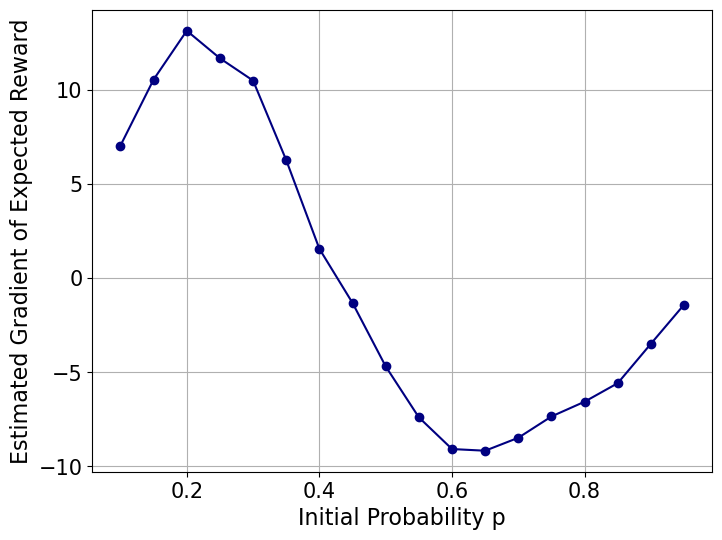

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6)) 
plt.plot(p_vals, grad, marker='o', color = "navy")
plt.xlabel('Initial Probability p', fontsize = 16)
plt.ylabel('Estimated Gradient of Expected Reward', fontsize = 16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title('REINFORCE Gradient vs Initial Probability in Game of Life')

plt.grid(True)
plt.savefig("probability.png", dpi=150)
plt.show()


In [95]:
#test against finite difference 

def reward(key, p, T, N, num_samples):
    keys = jax.random.split(key, num_samples)
    
    def one_iter(k):
        init = jax.random.bernoulli(k, p=p, shape=(N, N)).astype(jnp.int32)
        final = run_game(k, init, T)
        reward = jnp.sum(final)
        return reward

    #Vectorize over all simulations
    rewards = jax.vmap(one_iter)(keys)
    #Monte Carlo average
    return jnp.mean(rewards)

def finite_difference_estimate(p, key, T, N, num_samples=10000, h=1e-2):
    # Use common random numbers by fixing seeds
    key1, key2 = jax.random.split(key)
    
    # Compute E[R(x)] at p + h
    reward_plus = reward(key1, p + h, T, N, num_samples)
    
    # Compute E[R(x)] at p - h
    reward_minus = reward(key2, p - h, T, N, num_samples)
    
    # Central difference
    grad_fd = (reward_plus - reward_minus) / (2 * h)
    return grad_fd

key = jax.random.PRNGKey(42)
p = 0.5
T = 10
N = 10
num_samples = 100000

# REINFORCE gradient estimate
reinforce_grad = game_of_life(key, p, T, N, num_samples)

# Finite difference estimate
fd_grad = finite_difference_estimate(p, key, T, N, num_samples)

print(f"REINFORCE grad: {reinforce_grad:.4f}")
print(f"Finite diff grad: {fd_grad:.4f}")

#REINFORCE and Finite Difference Gradient match

REINFORCE grad: -28.7234
Finite diff grad: -29.5695


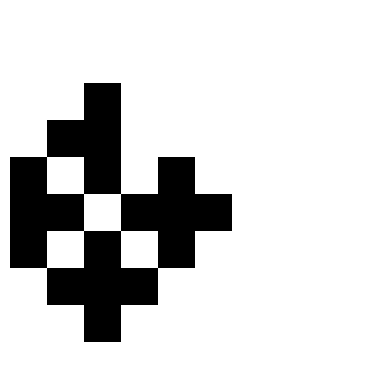

In [81]:
# Initialize grid
key = jax.random.PRNGKey(10)
N = 10
T = 10
grid = jax.random.bernoulli(key, p=0.1, shape=(N, N)).astype(jnp.int32)

# Precompute frames
frames = []
for _ in range(T):
    frames.append(np.array(grid))  # Convert from JAX to NumPy
    grid = update_stochastic(key, grid)

# Create plot
fig, ax = plt.subplots()
img = ax.imshow(frames[0], cmap='binary', interpolation='nearest')
ax.axis('off')  # Hide axes

def animate(i):
    img.set_data(frames[i])
    return [img]

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=100, blit=False)
#anim.save("game_of_life_5.mp4", writer="ffmpeg", fps=10)

plt.show()

